Time 1.9944678329999999


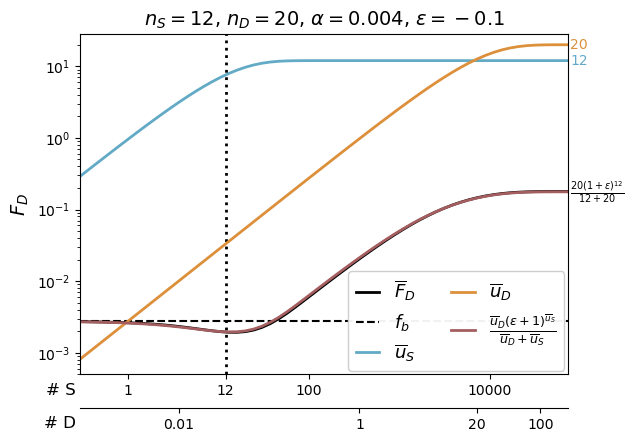

In [1]:
# Import required libraries
import matplotlib.pyplot as plt
import numpy as np
import numba as nb
import timeit
from matplotlib.ticker import MultipleLocator

# Setting a random seed ensures reproducibility of results
np.random.seed(42)


# Function to compute FD
@nb.njit()
def analytics(t, fs, fd, mus, mud):
    ns = len(fs)
    nd = len(fd)

    Ps = np.zeros(ns+1)
    Pd = np.zeros(nd)

    fs[::-1].sort()
    fd[::-1].sort()

    for i in range(ns):
        Ps[i] = (1 - np.exp(-t * mus)) * np.exp(-t * mus * i)
    Ps[ns] = np.exp(-t * mus *ns)

    for i in range(nd):
        Pd[i] = (1 - np.exp(-t * mud)) * np.exp(-t * mud * i)

    H = np.zeros((ns+1, nd))
    for i in range(ns):
        for j in range(nd):
            H[i, j] = fs[i] < fd[j]
    H[ns] = 1

    FD = np.dot(Ps,np.dot(H, Pd))/(1-np.exp(-t*(ns*mus+nd*mud)))
    #FD = np.dot(Ps,np.dot(H, Pd))

    return FD


# Parameter initializations
ns = 12
nd = 20
#alpha = 3*10**(-2)
alpha = 4*10**(-3)
epsilon= -0.1
mus = 1
mud = mus*alpha
mus = mus*3*0.76/5.89
mud = mud*3*0.99*0.52/9.63


landscapes = 10000
datapoints = 60
tmin = 10**(-1.2)
tmax = 10**(4.2)

# Create logarithmically spaced array for mutation supply
T = np.logspace(np.log10(tmin), np.log10(tmax), num=datapoints, base=10)  # mutation supply

# Initialize matrix to store all computed FD values across different landscapes
all_y = np.zeros((landscapes, datapoints))

start = timeit.default_timer()
counter = 0
for l in range(landscapes):
    fs = np.random.random(size=ns)
    fd = np.random.random(size=nd)*(1+epsilon)

    if np.amax(fd) > np.amax(fs):
        counter +=1

    y = np.zeros(len(T))
    for i in range(len(T)):
        y[i] = analytics(T[i], fs, fd, mus, mud)
    all_y[l] = y
stop = timeit.default_timer()
print("Time", stop-start)

# Plotting
fig = plt.figure(figsize=(6.3, 5))
ax1 = fig.add_subplot(111)
ax2 = ax1.twiny()
# Add some extra space for the second axis at the bottom
fig.subplots_adjust(bottom=0.2)

us = ns*(1-np.exp(-mus*T))
ud = nd*(1-np.exp(-mud*T))

ax1.plot(T, all_y.mean(axis=0), color="black", lw=2, label='$\\overline{F}_{D}$')
ax1.plot(T, [nd*(mud)/(nd*mud+ns*mus)]*len(T),"--", color="black", label='$f_b$')
ax1.plot(T, us, lw=2, label='$\\overline{u}_S$', color="#62AAC5")
ax1.axvline(x=1/mus, color="black", lw=2, linestyle="dotted")
#ax1.axvline(x=1/mud, color="black", lw=2, linestyle="dotted")
ax1.plot(T, ud, lw=2, label='$\\overline{u}_D$', color="#DD903B")

if epsilon > 0:
    ax1.plot(T, ((1 + epsilon) ** (-ud) * (-us + ud * (1 + epsilon) ** ud + us * (1 + epsilon) ** ud)) / (ud + us), label='new')
else:
    ax1.plot(T, ud*(1+epsilon)**us/(ud+us),  lw=2, color="#a45e5f", label='$\\frac{\\overline{u}_D (\\epsilon +1)^{\\overline{u}_S}}{\\overline{u}_D+\\overline{u}_S}$')

ax1.annotate(xy=(14000,20), xytext=(5, 0), textcoords='offset points', text="20", va='center', color="#DD903B")
ax1.annotate(xy=(14000,12), xytext=(5, 0), textcoords='offset points', text="12", va='center', color="#62AAC5")
ax1.annotate(xy=(14000,20*(1+epsilon)**ns/32), xytext=(5, 0), textcoords='offset points', text="$\\frac{20(1+\\epsilon)^{12}}{12+20}$", va='center', color="black")


ax1.set_xscale("log")
ax1.set_yscale("log")

# Set the x-ticks
ax1.set_xticks([1/(mus*ns), 12/(mus*ns), 100/(mus*ns),10000/(mus*ns), 100000/(mus*ns)])
ax1.set_xticklabels([1, 12, 100, 10000,100000])

# Set the fontsize for x-tick labels
ax1.tick_params(axis='x', labelsize=10)

ax1.set_xlabel("# S", fontsize=12)

ax2.set_xscale("log")
# Move twinned axis ticks and label from top to bottom
ax2.xaxis.set_ticks_position("bottom")
ax2.xaxis.set_label_position("bottom")

# Offset the twin axis below the host
ax2.spines["bottom"].set_position(("axes", -0.1))


ax2.set_frame_on(True)
ax2.patch.set_visible(False)
for sp in ax2.spines.values():
    sp.set_visible(False)
ax2.spines["bottom"].set_visible(True)

# Set the x-ticks
ax2.set_xticks([0.01/(mud*nd),1/(mud*nd),20/(mud*nd),100/(mud*nd),10000/(mud*nd),100000/(mud*nd)])
ax2.set_xticklabels([0.01, 1, 20, 100, 10000,100000])

# Set the fontsize for x-tick labels
ax2.tick_params(axis='x', labelsize=10)

ax2.set_xlabel("# D", fontsize=12)

ax1.xaxis.set_minor_locator(MultipleLocator(100000))
ax2.xaxis.set_minor_locator(MultipleLocator(100000))
ax1.xaxis.set_label_coords(-.04, -.025)
ax2.xaxis.set_label_coords(-.04, -.124)

plt.ylim(0.0005, 28)
ax1.set_xlim(tmin,tmax)
ax2.set_xlim(tmin,tmax)
ax1.set_ylabel("$F_{D}$", fontsize=14)
ax1.legend(fontsize=13, framealpha=0.95, loc=(0.55,0.01), ncol=2, handlelength=1.3)
plt.title("$n_S={}$, $n_D={}$, $\\alpha={}$, $\epsilon={}$".format(ns,nd,alpha, epsilon), fontsize=14)

#plt.savefig('simpleModelDip.pdf')
plt.show()